In [1]:
# Packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import random
import community as comm
import time
from gensim.models import Word2Vec

from sklearn.cluster import KMeans
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

import warnings
warnings.filterwarnings('ignore')

import torch 
import torchvision 
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GATConv
from torch_geometric.utils import to_networkx
import torchvision
import torchvision.transforms as transforms

%run ./helper.ipynb

In [2]:
# Load Cora dataset

from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='Cora', name='Cora')

In [3]:
# Creating dataframe to store the Computation Time and Accuracy of Node Embedding for the different GNN models

node_emb = pd.DataFrame(columns=['GCN','GraphSage','GAT'], index = ["Accuracy", "Execution Time (sec)", "CPU Execution Time (sec)"])

In [4]:
# Get the node embeddings for the desired GNN Model (GCN, GraphSage, GAT)

node_dict = {}

for i, j in zip([0,1,2],['GCN','GraphSage','GAT']):
    
    print(f'Generating Node Embeddings for {j}...')
    
    st, st_cpu = time.time(), time.process_time()
    node_dict[j], acc = gnn_embed(dataset, i)
    ct, ct_cpu = time.time() - st, time.process_time() - st_cpu
    
    print(f'Node Embeddings for {j} are generated!')
    
    node_emb.loc["Accuracy",j] = acc
    node_emb.loc["Execution Time (sec)",j] = ct
    node_emb.loc["CPU Execution Time (sec)",j] = ct_cpu

Generating Node Embeddings for GCN...
Epoch: 0, Train Accuracy: 0.7929
Epoch: 1, Train Accuracy: 0.9286
Epoch: 2, Train Accuracy: 0.9429
Epoch: 3, Train Accuracy: 0.9500
Epoch: 4, Train Accuracy: 0.9643
Epoch: 5, Train Accuracy: 0.9500
Epoch: 6, Train Accuracy: 0.9571
Epoch: 7, Train Accuracy: 0.9857
Epoch: 8, Train Accuracy: 0.9714
Epoch: 9, Train Accuracy: 0.9929
Epoch: 10, Train Accuracy: 0.9929
Epoch: 11, Train Accuracy: 0.9786
Epoch: 12, Train Accuracy: 0.9929
Epoch: 13, Train Accuracy: 0.9929
Epoch: 14, Train Accuracy: 0.9929
Epoch: 15, Train Accuracy: 0.9929
Epoch: 16, Train Accuracy: 1.0000

Test Accuracy: 0.7860

Total Accuracy: 0.8061

Node Embeddings for GCN are generated!
Generating Node Embeddings for GraphSage...
Epoch: 0, Train Accuracy: 0.5786
Epoch: 1, Train Accuracy: 0.7500
Epoch: 2, Train Accuracy: 0.7857
Epoch: 3, Train Accuracy: 0.9143
Epoch: 4, Train Accuracy: 0.9857
Epoch: 5, Train Accuracy: 0.9929
Epoch: 6, Train Accuracy: 1.0000

Test Accuracy: 0.7350

Total Ac

In [5]:
# Displaying Node Embedding metrics

node_emb

,GCN,GraphSage,GAT
Accuracy,0.80613,0.752216,0.762555
Execution Time (sec),0.973853,1.668583,0.828236
CPU Execution Time (sec),1.140625,3.25,1.5625


In [7]:
# Creating dataframe to store the Computation Time and Accuracy of Link Prediction for the different GNN models

link_pred = pd.DataFrame(columns=['GCN','GraphSage','GAT'], index = ["Accuracy", "Execution Time (sec)", "CPU Execution Time (sec)"])

In [8]:
# Get the Link Prediction probabilities of each edge along with the edge list for each GNN model (GCN, GraphSage, GAT)

probs, vlists = {}, {}

for i in ['GCN','GraphSage','GAT']:

    G = to_networkx(dataset[0])
    G1 = G.to_undirected()

    print(f'Getting Link Prediction probabilities of edges along with edge list for {i}...')
    st, st_cpu = time.time(), time.process_time()
    prob, vlist, acc = makeLinkPrediction(G1, node_dict[i])
    ct, ct_cpu = time.time() - st, time.process_time() - st_cpu
    
    probs[i] = prob
    vlists[i] = vlist
    
    print(f'Edge Probabilities and the corresponding Edge list for {i} are generated!\n')
        
    link_pred.loc["Accuracy",i] = acc
    link_pred.loc["Execution Time (sec)",i] = ct
    link_pred.loc["CPU Execution Time (sec)",i] = ct_cpu

Getting Link Prediction probabilities of edges along with edge list for GCN...
Link Prediction Accuracy: 0.8996212121212122
Edge Probabilities and the corresponding Edge list for GCN are generated!

Getting Link Prediction probabilities of edges along with edge list for GraphSage...
Link Prediction Accuracy: 0.9027777777777778
Edge Probabilities and the corresponding Edge list for GraphSage are generated!

Getting Link Prediction probabilities of edges along with edge list for GAT...
Link Prediction Accuracy: 0.9084595959595959
Edge Probabilities and the corresponding Edge list for GAT are generated!



In [9]:
# Displaying Link Prediction metrics

link_pred

,GCN,GraphSage,GAT
Accuracy,0.899621,0.902778,0.90846
Execution Time (sec),93.756651,97.458823,91.902236
CPU Execution Time (sec),90.703125,96.65625,90.890625


In [10]:
# Getting updated probabilities of each GNN model (GCN, GraphSage, GAT) for Heuristic 2

probs_upd = {}

for k in ['GCN','GraphSage','GAT']:

#     k_int = {i:1-j for i, j in zip(vlists[k],probs[k])}
#     sorted_k_int = sorted(k_int.items(), key=lambda x:x[1], reverse = True)
    
#     prob_int, vlist_int = [], []
#     for i,j in sorted_k_int:
#         vlist_int.append(i)
#         prob_int.append(i)
           
#     probs_upd[k] = {'Edge': vlist_int, 'Prob': prob_int}
    probs_upd[k] = [1-i for i in probs[k]]

In [11]:
# Creating a base copy of the graph

G = to_networkx(dataset[0])
OG = G.to_undirected()

In [12]:
# Creating dataframe to store the Computation Time for Random Heuristic for the different GNN models

random_cp_time = pd.DataFrame(columns=[0, 0.05, 0.1, 0.2, 0.25, 0.3, 0.33, 0.4, 0.5, 0.6], index = ['GCN','GraphSage','GAT', 'GCN (CPU)','GraphSage (CPU)','GAT (CPU)'])

In [13]:
# Sparsify the graph using Random Heuristic

random_sparsified_dict = {}

for p in [0, 0.05, 0.1, 0.2, 0.25, 0.3, 0.33, 0.4, 0.5, 0.6]:
    for g in ['GCN','GraphSage','GAT']:
        
        if p not in random_sparsified_dict.keys():
            random_sparsified_dict[p] = {'GCN':{},'GraphSage':{},'GAT':{}}
        
        if p == 0:
            random_sparsified_dict[p][g]['Graph'] = OG.copy()
            random_sparsified_dict[p][g]['Mask'] = [False] * OG.number_of_edges()
            
            g_new = g + ' (CPU)'
            random_cp_time.loc[g,p] = 0
            random_cp_time.loc[g_new,p] = 0
            
            continue
        
        st, st_cpu = time.time(), time.process_time()
        G = OG.copy()
        G_new, mask = sparsify_graph(G, list(G.edges()), probs_upd[g], p, 0)
        ct, ct_cpu = time.time() - st, time.process_time() - st_cpu
    
        # Print number of edges before and after sparsification using Heuristic
        print(f"Model: {g}, Sparsified %: {p}, Before Sparsification (edges): {len(OG.edges)}, After Sparsification (edges): {len(G_new.edges)}")

        g_new = g + ' (CPU)'
        random_cp_time.loc[g,p] = ct
        random_cp_time.loc[g_new,p] = ct_cpu
            
        random_sparsified_dict[p][g]['Graph'] = G_new
        random_sparsified_dict[p][g]['Mask'] = mask
        
    print("\n")
#     break



Model: GCN, Sparsified %: 0.05, Before Sparsification (edges): 5278, After Sparsification (edges): 5015
Model: GraphSage, Sparsified %: 0.05, Before Sparsification (edges): 5278, After Sparsification (edges): 5015
Model: GAT, Sparsified %: 0.05, Before Sparsification (edges): 5278, After Sparsification (edges): 5015


Model: GCN, Sparsified %: 0.1, Before Sparsification (edges): 5278, After Sparsification (edges): 4751
Model: GraphSage, Sparsified %: 0.1, Before Sparsification (edges): 5278, After Sparsification (edges): 4751
Model: GAT, Sparsified %: 0.1, Before Sparsification (edges): 5278, After Sparsification (edges): 4751


Model: GCN, Sparsified %: 0.2, Before Sparsification (edges): 5278, After Sparsification (edges): 4223
Model: GraphSage, Sparsified %: 0.2, Before Sparsification (edges): 5278, After Sparsification (edges): 4223
Model: GAT, Sparsified %: 0.2, Before Sparsification (edges): 5278, After Sparsification (edges): 4223


Model: GCN, Sparsified %: 0.25, Before Spars

In [14]:
# Displaying Computation times of sparsification using Random Heuristic 

random_cp_time

,0.00,0.05,0.10,0.20,0.25,0.30,0.33,0.40,0.50,0.60
GCN,0,1.381029,3.325149,4.054513,5.87217,5.800646,11.680565,7.793303,10.801527,11.33091
GraphSage,0,1.149366,3.850199,5.531659,5.235264,8.862872,10.810663,9.574806,10.616088,13.959698
GAT,0,1.37376,2.189645,5.442563,4.844524,10.017514,8.064803,9.264105,9.892169,12.642406
GCN (CPU),0,1.359375,3.328125,4.0625,5.15625,5.796875,10.171875,7.75,10.46875,10.953125
GraphSage (CPU),0,1.15625,3.8125,5.25,5.140625,7.90625,9.109375,9.3125,10.125,13.078125
GAT (CPU),0,1.34375,2.15625,4.703125,4.84375,8.921875,7.515625,9.1875,9.625,11.921875


<Figure size 1440x720 with 0 Axes>

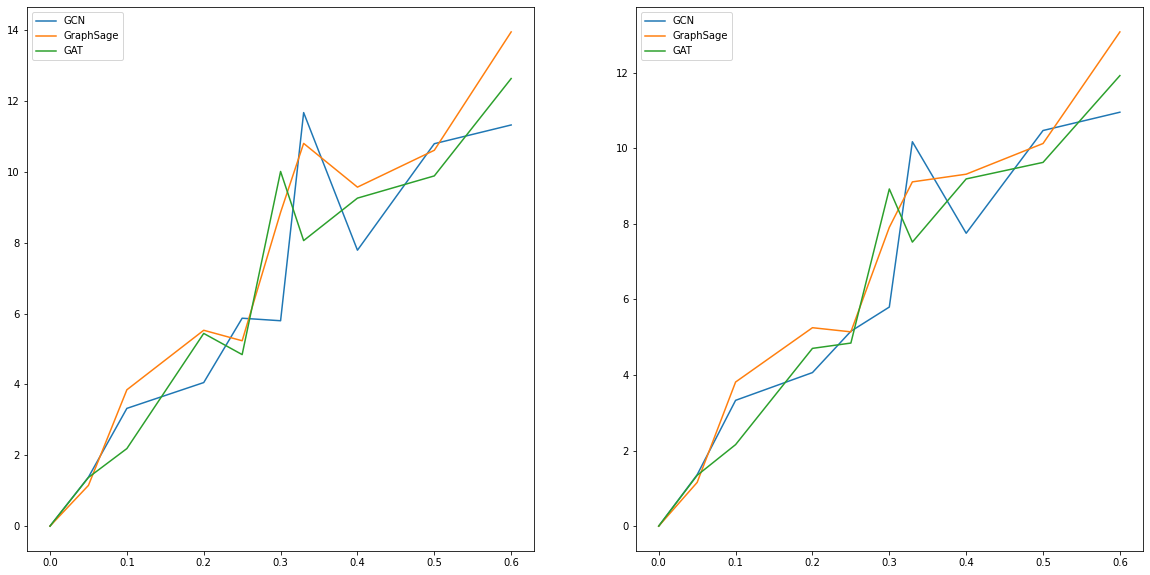

In [15]:
# Plotting the Computation times of the Sparsification of the graph

plt.figure(figsize=(20,10))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.plot(random_cp_time.columns, random_cp_time.loc['GCN',:],label='GCN')
ax1.plot(random_cp_time.columns, random_cp_time.loc['GraphSage',:],label='GraphSage')
ax1.plot(random_cp_time.columns, random_cp_time.loc['GAT',:],label='GAT')
ax1.legend()

ax2.plot(random_cp_time.columns, random_cp_time.loc['GCN (CPU)',:],label='GCN')
ax2.plot(random_cp_time.columns, random_cp_time.loc['GraphSage (CPU)',:],label='GraphSage')
ax2.plot(random_cp_time.columns, random_cp_time.loc['GAT (CPU)',:],label='GAT')
ax2.legend()


In [16]:
# Creating dataframe to store the Computation Time and Accuracy for Random Heuristic for the different GNN models

random_time_acc = pd.DataFrame(columns=[0, 0.05, 0.1, 0.2, 0.25, 0.3, 0.33, 0.4, 0.5, 0.6], index = ['GCN','GraphSage','GAT', 'GCN (CPU)','GraphSage (CPU)','GAT (CPU)', 'GCN (Acc)','GraphSage (Acc)','GAT (Acc)'])

# Getting the embeddings and finding the node classification accuracy for all the graphs

for p in [0, 0.05, 0.1, 0.2, 0.25, 0.3, 0.33, 0.4, 0.5, 0.6]:
    for g in ['GCN','GraphSage','GAT']:
    
        print(f"Configuration - Model:{g}, Sparsified %: {p*100}")
    
        st, st_cpu = time.time(), time.process_time()
    
        G = random_sparsified_dict[p][g]['Graph']
        walks_deepwalk = deepwalk_walks(G, walk_length=10, num_walks=80)
        embeddings_deepwalk = get_embedding(G,walks_deepwalk)
        acc = node_classification(embeddings_deepwalk, G, dataset)
        
        ct, ct_cpu = time.time() - st, time.process_time() - st_cpu
        
        g_new = g + ' (CPU)'
        g_acc = g + ' (Acc)'
        random_time_acc.loc[g,p] = ct
        random_time_acc.loc[g_new,p] = ct_cpu
        random_time_acc.loc[g_acc,p] = acc
        
        print("\n")
        

Configuration - Model:GCN, Sparsified %: 0
Learning embedding vectors...
Learning embedding vectors done!
Training classifier using 80.00% nodes...
-------------------
{'acc': 0.8247232472324724}
-------------------


Configuration - Model:GraphSage, Sparsified %: 0
Learning embedding vectors...
Learning embedding vectors done!
Training classifier using 80.00% nodes...
-------------------
{'acc': 0.8228782287822878}
-------------------


Configuration - Model:GAT, Sparsified %: 0
Learning embedding vectors...
Learning embedding vectors done!
Training classifier using 80.00% nodes...
-------------------
{'acc': 0.8468634686346863}
-------------------


Configuration - Model:GCN, Sparsified %: 5.0
Learning embedding vectors...
Learning embedding vectors done!
Training classifier using 80.00% nodes...
-------------------
{'acc': 0.8265682656826568}
-------------------


Configuration - Model:GraphSage, Sparsified %: 5.0
Learning embedding vectors...
Learning embedding vectors done!
Traini

In [17]:
# Displaying Computation times and Accuracy of getting embedding and find node classification accuracy using Random Heuristic 

random_time_acc

,0.00,0.05,0.10,0.20,0.25,0.30,0.33,0.40,0.50,0.60
GCN,58.394857,71.052935,64.884055,58.206689,59.188978,54.794622,46.853617,47.454783,44.382234,37.936651
GraphSage,62.108561,59.576123,56.792769,59.149919,54.56934,52.321896,48.942352,48.964971,50.206527,40.752364
GAT,61.868357,72.868916,63.14756,64.048786,53.592726,50.202626,52.486172,48.029693,45.525408,45.838346
GCN (CPU),144.6875,158.171875,153.375,142.671875,152.203125,146.03125,128.34375,127.28125,115.578125,101.015625
GraphSage (CPU),153.453125,154.71875,139.6875,146.984375,149.84375,141.890625,129.21875,127.125,118.78125,106.890625
GAT (CPU),149.96875,156.28125,147.890625,144.828125,144.984375,135.5625,141.078125,127.296875,112.375,109.09375
GCN (Acc),0.824723,0.826568,0.782288,0.769373,0.776753,0.761993,0.706642,0.688192,0.649446,0.584871
GraphSage (Acc),0.822878,0.793358,0.800738,0.776753,0.756458,0.736162,0.734317,0.715867,0.658672,0.583026
GAT (Acc),0.846863,0.791513,0.789668,0.791513,0.763838,0.749077,0.741697,0.710332,0.669742,0.603321


<Figure size 1440x720 with 0 Axes>

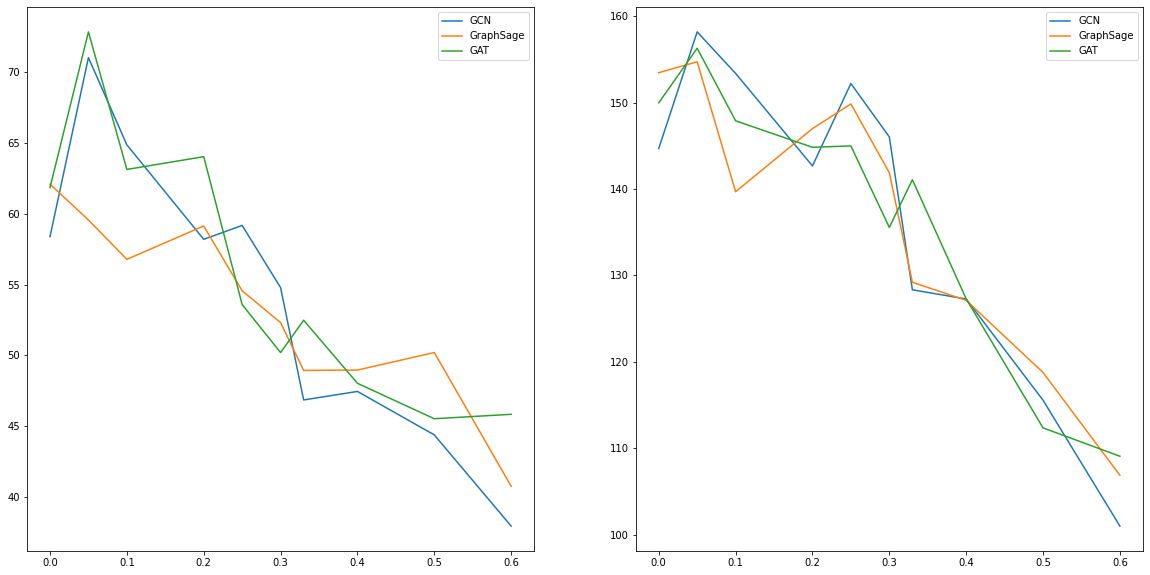

In [18]:
# Plotting the Computation times of getting embedding and find node classification accuracy for Random Heuristic

plt.figure(figsize=(20,10))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.plot(random_time_acc.columns, random_time_acc.loc['GCN',:],label='GCN')
ax1.plot(random_time_acc.columns, random_time_acc.loc['GraphSage',:],label='GraphSage')
ax1.plot(random_time_acc.columns, random_time_acc.loc['GAT',:],label='GAT')
ax1.legend()

ax2.plot(random_time_acc.columns, random_time_acc.loc['GCN (CPU)',:],label='GCN')
ax2.plot(random_time_acc.columns, random_time_acc.loc['GraphSage (CPU)',:],label='GraphSage')
ax2.plot(random_time_acc.columns, random_time_acc.loc['GAT (CPU)',:],label='GAT')
ax2.legend()

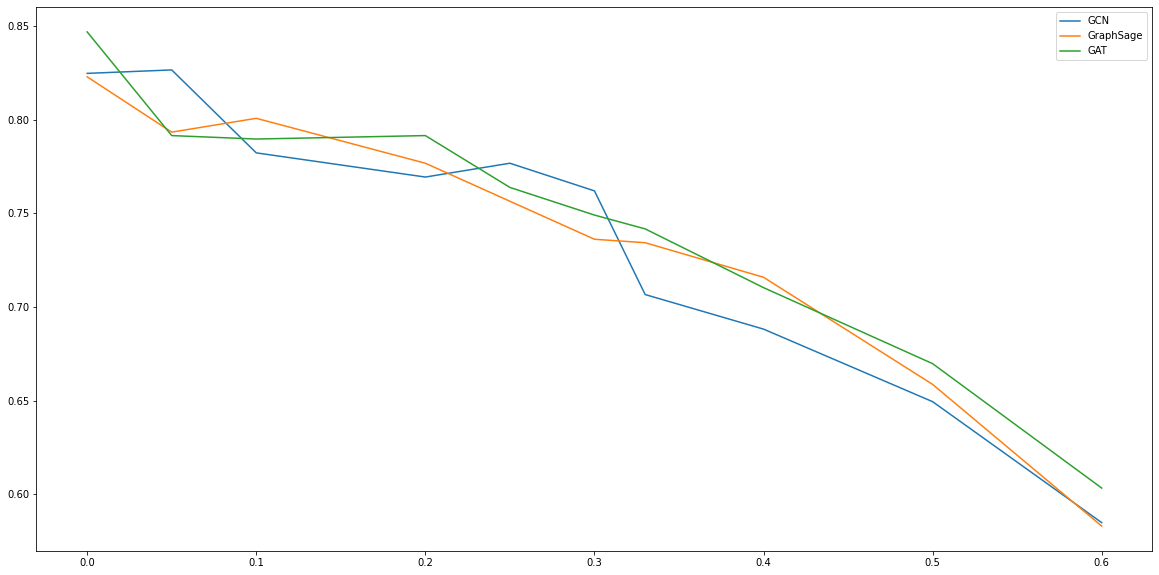

In [19]:
# Plotting the Accuracies of getting embedding and find node classification accuracy for Random Heuristic

plt.figure(figsize=(20,10))

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

plt.plot(random_time_acc.columns, random_time_acc.loc['GCN (Acc)',:],label='GCN')
plt.plot(random_time_acc.columns, random_time_acc.loc['GraphSage (Acc)',:],label='GraphSage')
plt.plot(random_time_acc.columns, random_time_acc.loc['GAT (Acc)',:],label='GAT')
plt.legend()
plt.show()

In [20]:
# Creating a base copy of graph

G = to_networkx(dataset[0])
OG = G.to_undirected()


In [21]:
# Creating dataframe to store the Computation Time for Random Heuristic for the different GNN models

heuristic_cp_time = pd.DataFrame(columns=[0, 0.05, 0.1, 0.2, 0.25, 0.3, 0.33, 0.4, 0.5, 0.6], index = ['GCN','GraphSage','GAT', 'GCN (CPU)','GraphSage (CPU)','GAT (CPU)'])


# Sparsify the graph using Random-Link Prediction Heuristic

heuristic_sparsified_dict = {}

for p in [0, 0.05, 0.1, 0.2, 0.25, 0.3, 0.33, 0.4, 0.5, 0.6]:
    for g in ['GCN','GraphSage','GAT']:
        
        if p not in heuristic_sparsified_dict.keys():
            heuristic_sparsified_dict[p] = {'GCN':{},'GraphSage':{},'GAT':{}}
        
        if p == 0:
            heuristic_sparsified_dict[p][g]['Graph'] = OG.copy()
            heuristic_sparsified_dict[p][g]['Mask'] = [False] * OG.number_of_edges()
            
            g_new = g + ' (CPU)'
            heuristic_cp_time.loc[g,p] = 0
            heuristic_cp_time.loc[g_new,p] = 0
            
            continue
        
        st, st_cpu = time.time(), time.process_time()
        G = OG.copy()
        G_new, mask = sparsify_graph(G, list(G.edges()), probs_upd[g], p, 1)
        ct, ct_cpu = time.time() - st, time.process_time() - st_cpu
    
        # Print number of edges before and after sparsification using Heuristic
        print(f"Model: {g}, Sparsified %: {p}, Before Sparsification (edges): {len(OG.edges)}, After Sparsification (edges): {len(G_new.edges)}")

        g_new = g + ' (CPU)'
        heuristic_cp_time.loc[g,p] = ct
        heuristic_cp_time.loc[g_new,p] = ct_cpu
            
        heuristic_sparsified_dict[p][g]['Graph'] = G_new
        heuristic_sparsified_dict[p][g]['Mask'] = mask
        
    print("\n")
#     break



Model: GCN, Sparsified %: 0.05, Before Sparsification (edges): 5278, After Sparsification (edges): 5015
Model: GraphSage, Sparsified %: 0.05, Before Sparsification (edges): 5278, After Sparsification (edges): 5015
Model: GAT, Sparsified %: 0.05, Before Sparsification (edges): 5278, After Sparsification (edges): 5015


Model: GCN, Sparsified %: 0.1, Before Sparsification (edges): 5278, After Sparsification (edges): 4751
Model: GraphSage, Sparsified %: 0.1, Before Sparsification (edges): 5278, After Sparsification (edges): 4751
Model: GAT, Sparsified %: 0.1, Before Sparsification (edges): 5278, After Sparsification (edges): 4751


Model: GCN, Sparsified %: 0.2, Before Sparsification (edges): 5278, After Sparsification (edges): 4223
Model: GraphSage, Sparsified %: 0.2, Before Sparsification (edges): 5278, After Sparsification (edges): 4223
Model: GAT, Sparsified %: 0.2, Before Sparsification (edges): 5278, After Sparsification (edges): 4223


Model: GCN, Sparsified %: 0.25, Before Spars

In [22]:
# Displaying Computation times of sparsification using Random-Link Prediction Heuristic 

heuristic_cp_time

,0.00,0.05,0.10,0.20,0.25,0.30,0.33,0.40,0.50,0.60
GCN,0,4.202113,4.468535,6.464079,7.406401,15.010741,8.873845,11.904161,11.634761,13.456595
GraphSage,0,4.640625,4.513649,6.670869,7.638539,8.739962,8.512499,9.76547,11.4479,13.279093
GAT,0,3.965677,6.647974,9.173198,10.845682,8.394379,9.025913,10.37154,15.026209,13.293643
GCN (CPU),0,4.171875,4.453125,6.4375,7.34375,13.03125,8.84375,11.609375,11.625,13.296875
GraphSage (CPU),0,4.625,4.453125,6.640625,7.59375,8.65625,8.5,9.765625,11.421875,13.1875
GAT (CPU),0,3.9375,6.21875,8.828125,9.125,8.375,9.015625,10.296875,14.34375,13.21875


<Figure size 1440x720 with 0 Axes>

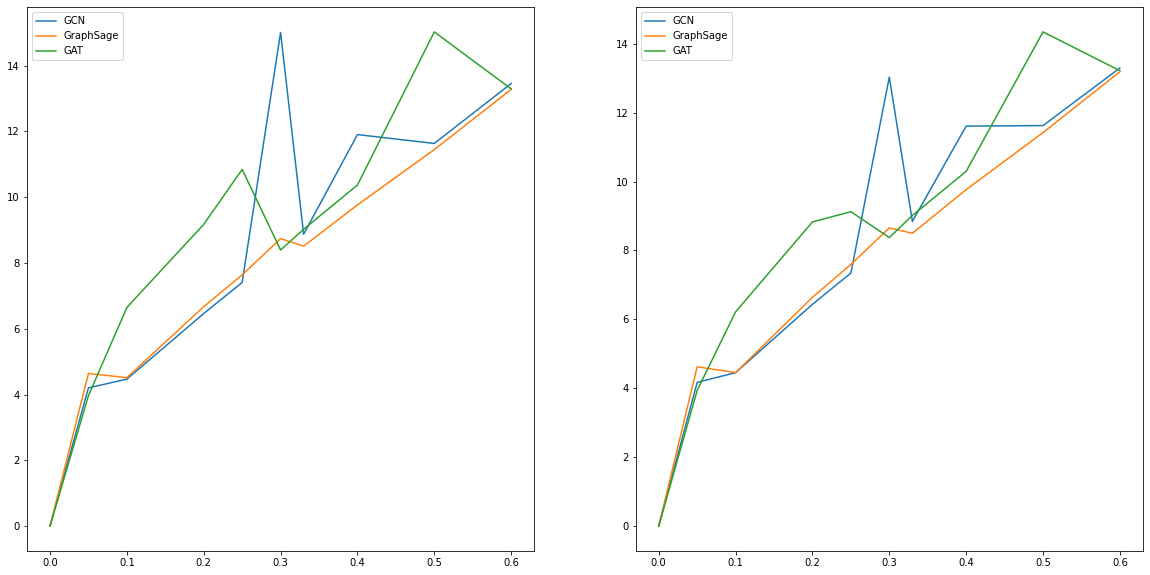

In [23]:
# Plotting the Computation times of the Sparsification of the graph

plt.figure(figsize=(20,10))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.plot(heuristic_cp_time.columns, heuristic_cp_time.loc['GCN',:],label='GCN')
ax1.plot(heuristic_cp_time.columns, heuristic_cp_time.loc['GraphSage',:],label='GraphSage')
ax1.plot(heuristic_cp_time.columns, heuristic_cp_time.loc['GAT',:],label='GAT')
ax1.legend()

ax2.plot(heuristic_cp_time.columns, heuristic_cp_time.loc['GCN (CPU)',:],label='GCN')
ax2.plot(heuristic_cp_time.columns, heuristic_cp_time.loc['GraphSage (CPU)',:],label='GraphSage')
ax2.plot(heuristic_cp_time.columns, heuristic_cp_time.loc['GAT (CPU)',:],label='GAT')
ax2.legend()
# ax2.plot(x, -y)

In [24]:
# Creating dataframe to store the Computation Time and Accuracy for Random-Link Prediction Heuristic for the different GNN models

heuristic_time_acc = pd.DataFrame(columns=[0, 0.05, 0.1, 0.2, 0.25, 0.3, 0.33, 0.4, 0.5, 0.6], index = ['GCN','GraphSage','GAT', 'GCN (CPU)','GraphSage (CPU)','GAT (CPU)', 'GCN (Acc)','GraphSage (Acc)','GAT (Acc)'])

# Getting the embeddings and finding the node classification accuracy for all the graphs

for p in [0, 0.05, 0.1, 0.2, 0.25, 0.3, 0.33, 0.4, 0.5, 0.6]:
    for g in ['GCN','GraphSage','GAT']:
    
        print(f"Configuration - Model:{g}, Sparsified %: {p*100}")
    
        st, st_cpu = time.time(), time.process_time()
    
        G = heuristic_sparsified_dict[p][g]['Graph']
        walks_deepwalk = deepwalk_walks(G, walk_length=10, num_walks=80)
        embeddings_deepwalk = get_embedding(G,walks_deepwalk)
        acc = node_classification(embeddings_deepwalk, G, dataset)
        
        ct, ct_cpu = time.time() - st, time.process_time() - st_cpu
        
        g_new = g + ' (CPU)'
        g_acc = g + ' (Acc)'
#         print(g_new, g_acc)
        heuristic_time_acc.loc[g,p] = ct
        heuristic_time_acc.loc[g_new,p] = ct_cpu
        heuristic_time_acc.loc[g_acc,p] = acc
        
        print("\n")
        
        

Configuration - Model:GCN, Sparsified %: 0
Learning embedding vectors...
Learning embedding vectors done!
Training classifier using 80.00% nodes...
-------------------
{'acc': 0.8191881918819188}
-------------------


Configuration - Model:GraphSage, Sparsified %: 0
Learning embedding vectors...
Learning embedding vectors done!
Training classifier using 80.00% nodes...
-------------------
{'acc': 0.8339483394833949}
-------------------


Configuration - Model:GAT, Sparsified %: 0
Learning embedding vectors...
Learning embedding vectors done!
Training classifier using 80.00% nodes...
-------------------
{'acc': 0.8321033210332104}
-------------------


Configuration - Model:GCN, Sparsified %: 5.0
Learning embedding vectors...
Learning embedding vectors done!
Training classifier using 80.00% nodes...
-------------------
{'acc': 0.8081180811808119}
-------------------


Configuration - Model:GraphSage, Sparsified %: 5.0
Learning embedding vectors...
Learning embedding vectors done!
Traini

In [25]:
# Displaying Computation times and Accuracy of getting embedding and find node classification accuracy 
# using Random-Link Prediction Heuristic 

heuristic_time_acc

,0.00,0.05,0.10,0.20,0.25,0.30,0.33,0.40,0.50,0.60
GCN,57.933494,54.406493,60.637065,66.375456,70.234634,57.713017,51.543534,45.988165,43.059726,37.026391
GraphSage,62.272566,62.057733,61.156608,66.00327,58.93541,55.590149,57.791702,45.021136,42.626137,37.71587
GAT,56.951274,61.697245,68.899535,66.731402,58.327039,49.723551,49.75491,44.919308,42.261379,35.01746
GCN (CPU),152.875,149.265625,156.53125,162.171875,137.984375,130.140625,130.3125,124.734375,115.578125,97.953125
GraphSage (CPU),167.03125,151.34375,151.8125,140.140625,134.953125,132.578125,144.984375,121.953125,111.53125,96.53125
GAT (CPU),154.3125,154.1875,157.21875,140.84375,142.625,127.84375,133.46875,121.453125,110.109375,93.921875
GCN (Acc),0.819188,0.808118,0.817343,0.791513,0.769373,0.750923,0.743542,0.715867,0.664207,0.571956
GraphSage (Acc),0.833948,0.811808,0.822878,0.806273,0.769373,0.795203,0.752768,0.739852,0.654982,0.605166
GAT (Acc),0.832103,0.828413,0.797048,0.789668,0.750923,0.758303,0.714022,0.667897,0.638376,0.549815


<Figure size 1440x720 with 0 Axes>

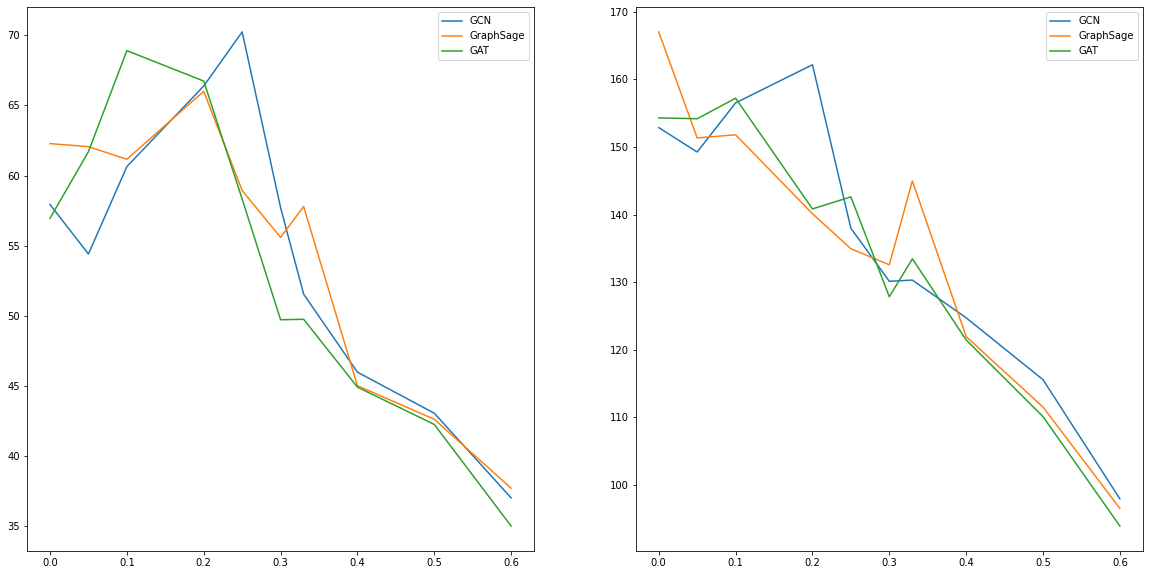

In [27]:
# Plotting the Computation times of getting embedding and find node classification accuracy for Random-Link Prediction Heuristic

plt.figure(figsize=(20,10))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.plot(heuristic_time_acc.columns, heuristic_time_acc.loc['GCN',:],label='GCN')
ax1.plot(heuristic_time_acc.columns, heuristic_time_acc.loc['GraphSage',:],label='GraphSage')
ax1.plot(heuristic_time_acc.columns, heuristic_time_acc.loc['GAT',:],label='GAT')
ax1.legend()

ax2.plot(heuristic_time_acc.columns, heuristic_time_acc.loc['GCN (CPU)',:],label='GCN')
ax2.plot(heuristic_time_acc.columns, heuristic_time_acc.loc['GraphSage (CPU)',:],label='GraphSage')
ax2.plot(heuristic_time_acc.columns, heuristic_time_acc.loc['GAT (CPU)',:],label='GAT')
ax2.legend()

plt.show()

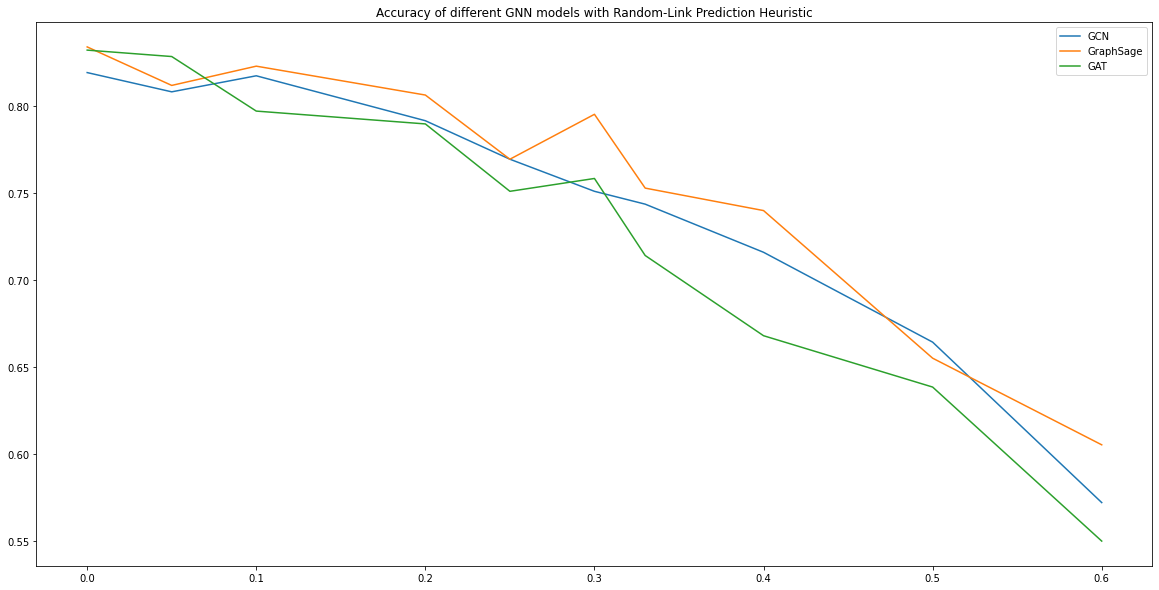

In [28]:
# Plotting the Accuracies of getting embedding and find node classification accuracy for Random-Link Prediction Heuristic

plt.figure(figsize=(20,10))

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

plt.plot(heuristic_time_acc.columns, heuristic_time_acc.loc['GCN (Acc)',:],label='GCN')
plt.plot(heuristic_time_acc.columns, heuristic_time_acc.loc['GraphSage (Acc)',:],label='GraphSage')
plt.plot(heuristic_time_acc.columns, heuristic_time_acc.loc['GAT (Acc)',:],label='GAT')
plt.legend()
plt.title("Accuracy of different GNN models with Random-Link Prediction Heuristic")
plt.show()

<Figure size 1440x720 with 0 Axes>

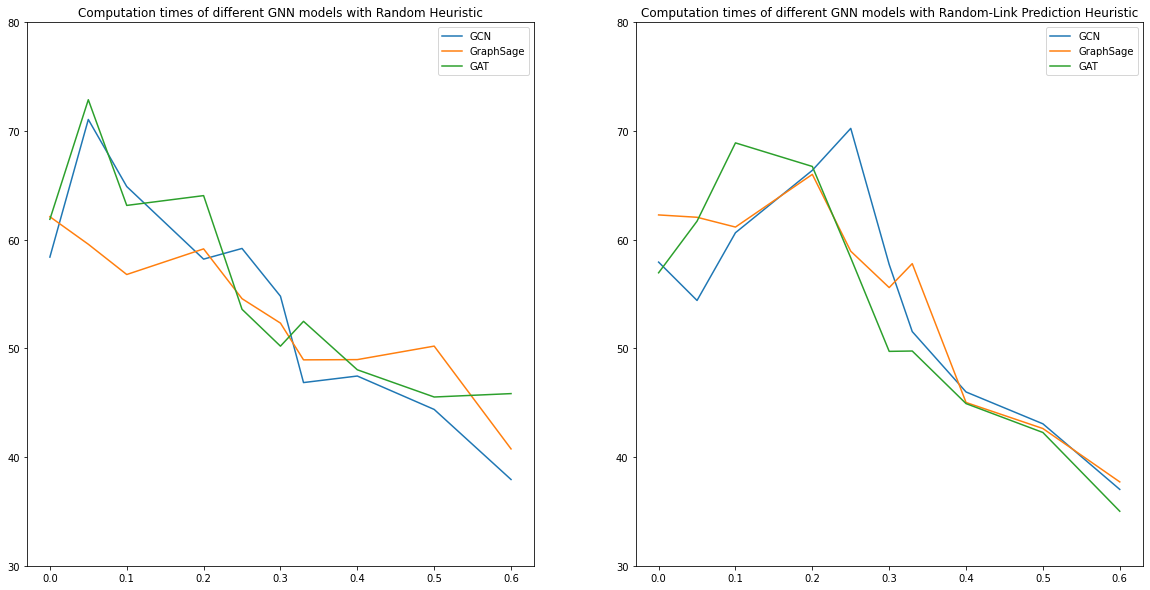

In [38]:
# Plotting the Computation times of getting embedding and find node classification accuracy for both the Heuristics

plt.figure(figsize=(20,10))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.plot(random_time_acc.columns, random_time_acc.loc['GCN',:],label='GCN')
ax1.plot(random_time_acc.columns, random_time_acc.loc['GraphSage',:],label='GraphSage')
ax1.plot(random_time_acc.columns, random_time_acc.loc['GAT',:],label='GAT')
ax1.legend()
ax1.set_ylim([30, 80])
ax1.set_title("Computation times of different GNN models with Random Heuristic")

ax2.plot(heuristic_time_acc.columns, heuristic_time_acc.loc['GCN',:],label='GCN')
ax2.plot(heuristic_time_acc.columns, heuristic_time_acc.loc['GraphSage',:],label='GraphSage')
ax2.plot(heuristic_time_acc.columns, heuristic_time_acc.loc['GAT',:],label='GAT')
ax2.legend()
ax2.set_ylim([30, 80])
ax2.set_title("Computation times of different GNN models with Random-Link Prediction Heuristic")

plt.show()

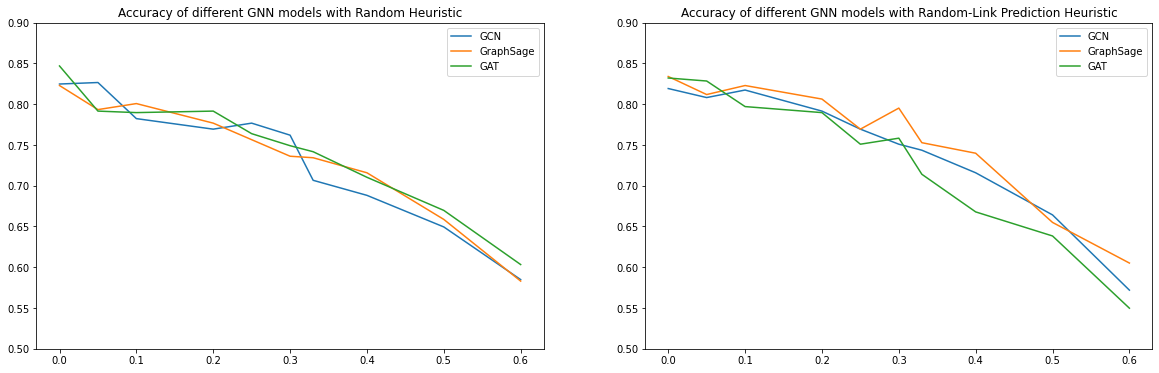

In [37]:
# Plotting the Accuracies of getting embedding and find node classification accuracy for both the Heuristics

# plt.figure(figsize=(20,10))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

ax1.plot(random_time_acc.columns, random_time_acc.loc['GCN (Acc)',:],label='GCN')
ax1.plot(random_time_acc.columns, random_time_acc.loc['GraphSage (Acc)',:],label='GraphSage')
ax1.plot(random_time_acc.columns, random_time_acc.loc['GAT (Acc)',:],label='GAT')
ax1.legend()
ax1.set_ylim([0.5, 0.9])
ax1.set_title("Accuracy of different GNN models with Random Heuristic")

ax2.plot(heuristic_time_acc.columns, heuristic_time_acc.loc['GCN (Acc)',:],label='GCN')
ax2.plot(heuristic_time_acc.columns, heuristic_time_acc.loc['GraphSage (Acc)',:],label='GraphSage')
ax2.plot(heuristic_time_acc.columns, heuristic_time_acc.loc['GAT (Acc)',:],label='GAT')
ax2.legend()
ax2.set_ylim([0.5, 0.9])
ax2.set_title("Accuracy of different GNN models with Random-Link Prediction Heuristic")

plt.show()